In [59]:
# ============================================================================
# Neural Style Transfer with TensorFlow
# ============================================================================
# This notebook demonstrates Neural Style Transfer (NST), a technique that 
# uses deep learning to compose images in the style of another image.
# The algorithm takes two images - a "content" image and a "style" image -
# and blends them together so the output looks like the content image but
# "painted" in the style of the style reference image.

# ---------- PART: SETUP AND IMPORTS ----------

# Import necessary libraries
import tensorflow as tf          # Deep learning framework
import IPython.display as display    # For display in notebook
import matplotlib.pyplot as plt      # For visualization
import matplotlib as mpl
import numpy as np                   # For numerical operations
import PIL.Image                     # For image processing
import time                          # For timing the process
import functools                     # For function utilities

# Check TensorFlow version and available GPUs for acceleration
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))    # https://developer.nvidia.com/cuda-12-8-0-download-archive?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exe_local



TensorFlow version: 2.19.0
GPU Available:  []


In [ ]:
# Define paths to content and style images
content_path = './creation_of_adam.jpg'  # The image to be transformed
style_path = './chrurch_windows.jpg'            # The style reference image

# Define constants for image processing
MAX_DIM = 512       # Maximum dimension (width & height) for generating/modeling images
IMG_CHANNELS = 3    # Number of channels in the image (RGB)

epochs = 5              # Number of iterations over all steps
steps_per_epoch = 50   # Number of optimization steps per epoch


VGG19 = True    # Flag to use VGG19 model for feature extraction
VGG16 = False   # Flag to use VGG16 model for feature extraction

# Define loss weights - these control the balance between content and style
# Higher style_weight means more emphasis on matching the style
# Higher content_weight means more emphasis on preserving content
style_weight = 1e-2    # Weight for style loss
content_weight = 1e4   # Weight for content loss - much higher to prioritize content

# Define which layers to use for content & style features
content_layers = ['block5_conv2']   # Content layer - higher layer for high-level features | Objects, shapes, etc.

# Style layers - multiple layers for capturing style features 
style_layers = ['block1_conv1',     # Fine details, textures
                'block2_conv1',     # Slightly more complex features
                'block3_conv1',     # Medium complexity patterns
                'block4_conv1',     # More complex patterns
                'block5_conv1']     # Large-scale structures

# saving Picture & information of this run
SAVE = False                            # Flag to save the generated image and settings
save_path = 'Settings.txt'
save_img = 'generated_image.jpg' 

# Create a configuration dictionary to store image parameters
img_config = {
    "content_path": content_path,
    "style_path": style_path,
    "max_dimension": MAX_DIM,
    "channels": IMG_CHANNELS,
    "dtype": tf.float32,       # Data type for image tensors
    "pixel_range": [0.0, 1.0]  # Range of pixel values after normalization
}


Image processing configuration:
  - content_path: ./creation_of_adam.jpg
  - style_path: ./chrurch_windows.jpg
  - max_dimension: 512
  - channels: 3
  - dtype: <dtype: 'float32'>
  - pixel_range: [0.0, 1.0]


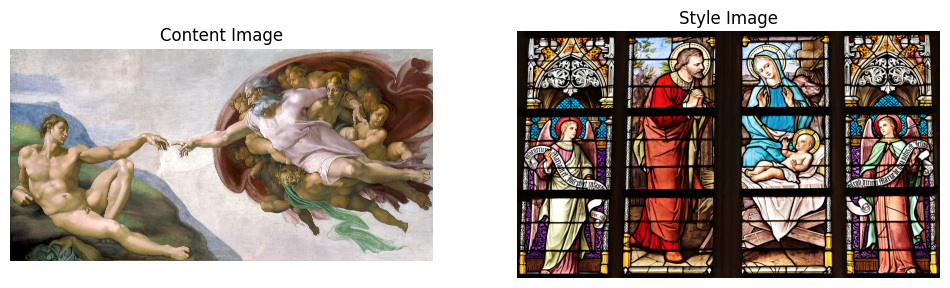

In [61]:
print("Image processing configuration:") 
for key, value in img_config.items():
    print(f"  - {key}: {value}")

content = PIL.Image.open(content_path)
style = PIL.Image.open(style_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title("Content Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title("Style Image")
plt.axis('off')

plt.show()  

In [62]:
# ---------- IMAGE LOADING AND PREPROCESSING ----------
def load_img(path_to_img, max_dim=None):
    # If max_dim is not provided, use the value from img_config
    if max_dim is None:
        max_dim = img_config["max_dimension"]
    
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=img_config["channels"])   # Decode image to tensor with specified channels
    img = tf.image.convert_image_dtype(img, img_config["dtype"])        # Convert image to float32 or other specified dtype 
    
    # Calculate scaling factor to maintain aspect ratio 
    shape = tf.cast(tf.shape(img)[:-1], tf.float32) # Get shape of image tensor (excluding channels) 
                                                    # [:-1] deletes last element and only keeps first two dimensions (height and width)
    long_dim = max(shape)                           # Get the longest dimension (height or width) of the image
    scale = max_dim / long_dim                      # Calculate scaling factor to maintain aspect ratio out of max_dim
    
   #---------------------------------------------------------------------------#
    new_shape = tf.cast(shape * scale, tf.int32)  
    img = tf.image.resize(img, new_shape)           # Resize image to new shape      
    img = img[tf.newaxis, :]                        # Add batch dimension to image tensor (for processing multiple images) 
                                                    # -> into: [Batchsize, height, width, channels]
    
    return img 

def imshow(image, title=None):
    """Displays an image using matplotlib."""
    # Remove batch dimension if present
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

def tensor_to_image(tensor):
    """Converts a tensor to a PIL Image object."""
    # Scale image using the pixel_range from img_config
    tensor = tensor * (img_config["pixel_range"][1] - img_config["pixel_range"][0])
    tensor = np.array(tensor, dtype=np.uint8)
    # Remove batch dimension if present
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


# Load both images 
content_image = load_img(content_path)  
style_image = load_img(style_path)


In [63]:

# Creates a model that returns the activations of specified VGG19 layers.
# layer_names: List of VGG19 layer names to extract features from
# RETURNS: A TensorFlow Keras model outputting selected layer activations
def vgg19_layers(layer_names):

    # Load pre-trained VGG19 model (without classification head) 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')    # 'imagenet' means weights pre-trained on ImageNet dataset
    vgg.trainable = False  # Freeze the model - we don't want to train it we want change the "input-Data" not the weights of the model
    
    # Create outputs for each requested layer
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # Create a new model with our desired outputs
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Creates a model that returns the activations of specified VGG16 layers.
# layer_names: List of VGG16 layer names to extract features from
# RETURNS: A TensorFlow Keras model outputting selected layer activations
def vgg16_layers(layer_names):

    # Load pre-trained VGG16 model (without classification head)
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(MAX_DIM, MAX_DIM, IMG_CHANNELS))
    vgg.trainable = False  # Freeze the model – we only use it for feature extraction
    
    # Create outputs for each requested layer
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # Create a new model with our desired outputs
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Create a model that returns the style and content feature activations
# Store layer counts for loss calculation
num_content_layers = len(content_layers) # all layers are used for calc content loss
num_style_layers = len(style_layers) 



In [64]:
# ---------- STYLE REPRSENTATION - GRAM MATRIX ----------
# The Gram matrix measures the correlations between the feature maps of a convolutional layer.
# This extracts textures, patterns, and color styles regardless of their spatial location – a key aspect of Neural Style Transfer.

# Calculate style representation using Gram matrix
def gram_matrix(input_tensor):  # RETURNS: Normalized Gram matrix
                                # input_tensor: A feature tensor from a convolutional layer
    """
    Computes correlations between feature maps, capturing style (textures, patterns, colors)
    without considering their arrangement on the plane.
    """
    # Calculate dot products between feature maps 
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)     # 'bijc,bijd->bcd' multiplies each feature map with all others
    
    # Normalize by the number of locations (height × width)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)  
    
    # Return normalized Gram matrix
    return result/(num_locations)


In [ ]:
# ---------- STYLE CONTENT MODEL ----------
# Create a custom model to extract content and style features
class StyleContentModel(tf.keras.models.Model):

    # Initialize the model with specified style and content layers.
    # style_layers: List of VGG layers to extract style features from
    # content_layers: List of VGG layers to extract content features from
    def __init__(self, style_layers, content_layers):

        super(StyleContentModel, self).__init__()
        if VGG19:
            # Uses the vgg_layers() function to create a submodel that outputs only these layers
            self.vgg = vgg19_layers(style_layers + content_layers) # combine Style- und Content-Layer in a list ['block1_conv1', ..., 'block5_conv2']
        if VGG16:
            self.vgg = vgg16_layers(style_layers + content_layers)
            
        self.style_layers = style_layers                 
        self.content_layers = content_layers

        self.num_style_layers = len(style_layers) # number of style layers
        
        self.vgg.trainable = False # frozen model we dont want to train, we want to change input data

# ---------------------------------------------------------------------------- #
    # Extract style and content features from the input image.
    # RETURNS: Dictionary containing style and content feature representations
    def call(self, inputs):

        # Preprocess for VGG19 | scale to [0,255] and apply specific preprocessing
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        outputs = self.vgg(preprocessed_input) # Get all requested layer outputs
        
        # Split outputs into style and content
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        # Calculate gram matrices for style outputs to capture texture information
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        # Create dictionaries mapping layer names to outputs
        content_dict = {content_name: value
                       for content_name, value
                       in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name: value
                     for style_name, value
                     in zip(self.style_layers, style_outputs)}
        
        # Return both dictionaries
        return {'content': content_dict, 'style': style_dict}


# ---- Create an instance of the StyleContentModel with specified layers --------------------
extractor = StyleContentModel(style_layers, content_layers) # Create the feature extraction model

# Extract style and content targets from our style and content images
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


C:\Users\marcn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_98']
Received: inputs=Tensor(shape=(1, 298, 512, 3))
  warnings.warn(msg)
C:\Users\marcn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_98']
Received: inputs=Tensor(shape=(1, 257, 511, 3))
  warnings.warn(msg)


In [66]:
# ---------- LOSS FUNCTIONS AND OPTIMIZATION SETUP ----------

# Calculate the total loss combining style and content differences.
# outputs: Dictionary with style and content features of the generated image
# RETURNS: Total loss value | weighted sum of style and content losses together
def style_content_loss(outputs):
 
    style_outputs = outputs['style']        # Extract style features from the model output
    content_outputs = outputs['content']
    
    # Style Loss: MSE between Gram matrices of the generated image and the style target
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                          for name in style_outputs.keys()])
    # Scale by style weight and number of style layers
    style_loss *= style_weight / num_style_layers
    
    # Calculate content loss - mean squared difference between content representations
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                            for name in content_outputs.keys()])
    # Scale by content weight and number of content layers
    content_loss *= content_weight / num_content_layers
    
    # Total loss is the sum of style and content losses
    total_loss = style_loss + content_loss
    return total_loss

# Create optimizer - Adam with custom parameters for style transfer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) 

# Initialize the image to optimize - start with the content image
# This will be the variable we update during optimization
image = tf.Variable(content_image)



In [67]:
# ---------- TOTAL VARIATION LOSS FOR SMOOTHNESS ----------

# Calculate the horizontal and vertical differences of an image.
# image: Input image tensor
# RETURNS: Tuple of tensors containing horizontal and vertical differences
def high_pass_x_y(image):

    # Calculate differences in x direction (horizontally)
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :] 
    # Calculate differences in y direction (vertically)
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

# Calculate total variation loss to encourage spatial smoothness.
# image: Input image tensor
# RETURNS: Total variation loss value
# This loss penalizes large differences between neighboring pixels,
def total_variation_loss(image):

    x_deltas, y_deltas = high_pass_x_y(image) # Calculate differences in x and y directions
    # Sum of absolute values of differences
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

# Weight for total variation loss - higher values create smoother images
total_variation_weight = 30



In [68]:
# ---------- TRAINING STEP WITH GRADIENT TAPE ----------

# Perform one optimization step to update the image.
# image: The image variable to update
# RETURNS: The loss value after this step
@tf.function()  # This decorator compiles the function for faster execution
def train_step(image):

    # Use gradient tape to track operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Extract features from the current image
        outputs = extractor(image)
        # Calculate style and content losses
        loss = style_content_loss(outputs)
        # Add total variation loss for smoothness
        loss += total_variation_weight * total_variation_loss(image)
    
    # Calculate gradients of the loss with respect to the image
    grad = tape.gradient(loss, image)
    # Apply gradients using the optimizer
    opt.apply_gradients([(grad, image)])
    # Clip pixel values to valid range [0, 1]
    image.assign(tf.clip_by_value(image, 0.0, 1.0))
    return loss



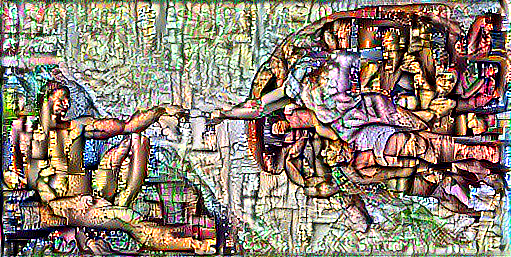

Train step: 250
Loss: 65222480.0
Total time: 293.7 seconds


In [69]:
# ---------- TRAINING  ----------

start = time.time()
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(image)
        print(".", end='', flush=True)  # Progress indicator
    
    # Display current result after each epoch
    # Convert image values from [0,1] to [0,255] and create a proper uint8 image
    img_uint8 = tf.clip_by_value(image * 255, 0, 255)
    img_uint8 = tf.cast(img_uint8, tf.uint8).numpy()
    img_uint8 = np.squeeze(img_uint8, axis=0)
    display.clear_output(wait=True)
    display.display(PIL.Image.fromarray(img_uint8))
    print(f"Train step: {step}")
    print(f"Loss: {loss:.1f}")

# Record total execution time
end = time.time()
print(f"Total time: {end-start:.1f} seconds")


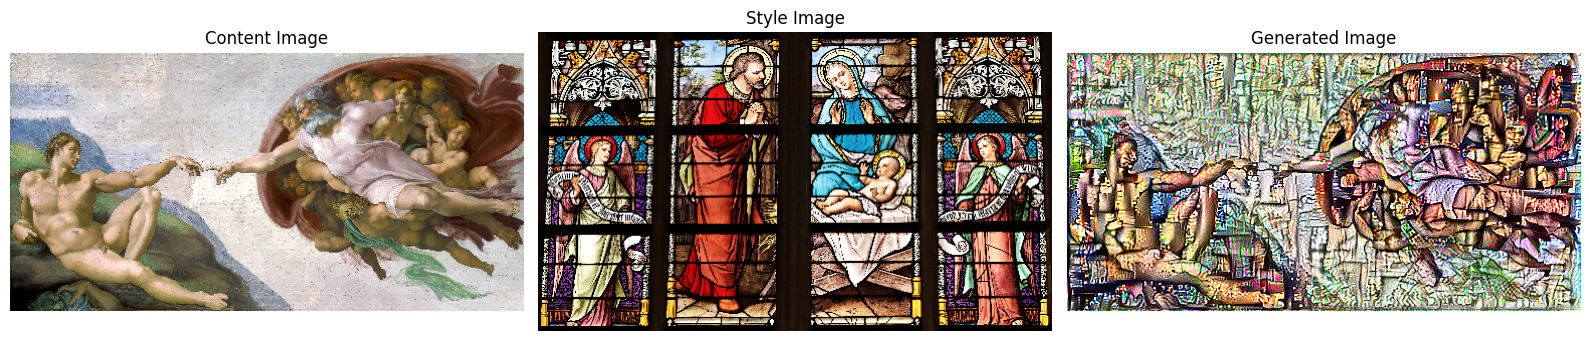

In [70]:
# ---------- SAVE AND DISPLAY RESULTS ----------

# Save the resulting image to disk
result = tensor_to_image(image)
    
if SAVE:
    result.save(save_img)
    result.save(save_path)

# Display final results - content, style, and generated images
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image')
plt.subplot(1, 3, 3)
imshow(tf.squeeze(image), 'Generated Image')
plt.tight_layout()
plt.show()



In [71]:
# ---------- DOCUMENTATION ----------
# Create a text file with settings and statistics
if SAVE:
    with open(save_path, 'w') as f:
        f.write("Neural Style Transfer Settings and Statistics\n")
        f.write("===========================================\n\n")
        f.write("Pretrained model used: VGG19\n")
        f.write(f"Content layers: {content_layers}\n")
        f.write(f"Style layers: {style_layers}\n")
        f.write(f"Content weight: {content_weight}\n")
        f.write(f"Style weight: {style_weight}\n")
        f.write(f"Total variation weight: {total_variation_weight}\n")
        f.write(f"Number of epochs: {epochs}\n")
        f.write(f"Steps per epoch: {steps_per_epoch}\n")
        f.write(f"Total iterations: {epochs * steps_per_epoch}\n")
        f.write(f"Time needed to produce image: {end-start:.1f} seconds\n")

# Create and display markdown with the same information
markdown_text = """
## Neural Style Transfer Settings and Statistics

### Model Information
- **Pretrained model used:** VGG19
- **Content layers:** {content_layers}
- **Style layers:** {style_layers}

### Optimization Parameters
- **Content weight:** {content_weight}
- **Style weight:** {style_weight}
- **Total variation weight:** {total_variation_weight}

### Training Details
- **Number of epochs:** {epochs}
- **Steps per epoch:** {steps_per_epoch}
- **Total iterations:** {total_iterations}
- **Time needed to produce image:** {time_taken:.1f} seconds
""".format(
    content_layers=content_layers,
    style_layers=style_layers,
    content_weight=content_weight,
    style_weight=style_weight,
    total_variation_weight=total_variation_weight,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    total_iterations=epochs * steps_per_epoch,
    time_taken=end-start
)

# Display markdown in the notebook
display.display(display.Markdown(markdown_text))


## Neural Style Transfer Settings and Statistics

### Model Information
- **Pretrained model used:** VGG19
- **Content layers:** ['block5_conv2']
- **Style layers:** ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

### Optimization Parameters
- **Content weight:** 10000.0
- **Style weight:** 0.01
- **Total variation weight:** 30

### Training Details
- **Number of epochs:** 5
- **Steps per epoch:** 50
- **Total iterations:** 250
- **Time needed to produce image:** 293.7 seconds
